In [1]:
""" https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
https://user.ceng.metu.edu.tr/~emre/resources/courses/AdvancedDL_Spring2017/DQN_Muhammed.pdf
https://www.youtube.com/watch?v=NP8pXZdU-5U&t=1s """
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from SnakeEnvironment import *
from Agent import *
import collections
import random
from itertools import count

pygame 2.1.2 (SDL 2.0.18, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


TRY:
- Longer training
- More layers in NN
- Bigger layers in NN
- Different loss

Epsilon projection:


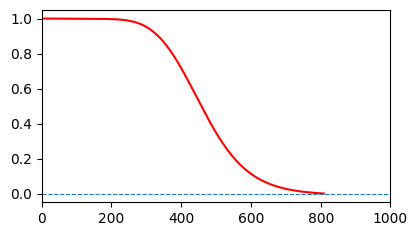

In [2]:
""" BEST: Try Decay: 0.00002, Lr 0.00005 w. exponential eps. decay in each episode (multiply w. (1-decay_rate)) for 1300 episodes and memory_size = 100000, gamma = 0.99, target_update = 25, batch_size = 64, apple_reward = 1.5, death_reward = -1.5,
 without distance to tail."""

""" Try Decay: 0.000005, Lr 0.00005 w. linear eps. decay in each time step (add -decay_rate) and
     memory_size = 1000000, gamma = 0.99, target_update = 50, batch_size = 64. """

""" Try Decay: 0.00002, Lr 0.00005 w. exponential eps. decay in each episode (multiply w. (1-decay_rate)) for 1000 episodes and
     memory_size = 1000000, gamma = 0.99, target_update = 50, batch_size = 64. """

""" Try Decay: 0.00002, Lr 0.00005 w. exponential eps. decay in each episode (multiply w. (1-decay_rate)) for 1000 episodes and
     memory_size = 100000, gamma = 0.999, target_update = 25, batch_size = 128. """

BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.0
EPS_DECAY = 0.002
TARGET_UPDATE = 50
MY_SEED = 143
LR = 0.00005
MEMORY_SIZE = 1000000

NUM_EPISODES = 1000

state_size = 17
nr_actions = 4

agent_007 = Agent(gamma=GAMMA,exploration_rate=EPS_START,lr=LR,
                  input_size=state_size, batch_size=BATCH_SIZE,
                  nr_actions=nr_actions, max_mem_size=MEMORY_SIZE,
                  nr_episodes=NUM_EPISODES, exploration_rate_min=EPS_END,
                  exploration_decay_rate=EPS_DECAY,seed=MY_SEED)

print("Epsilon projection:")
fig, ax = plt.subplots(1,1,figsize=(4.5,2.5))
eps = np.linspace(0,NUM_EPISODES,1000)
#ys = 1.0 - EPS_DECAY * eps
#ys = oscillator(eps,NUM_EPISODES)
ys = stretched_exponential(eps,NUM_EPISODES,A=0.5,B=0.15,C=0.01)
eps, ys = eps[ys >= 0], ys[ys >= 0]
ax.plot(eps, ys,'r-')
ax.set_xlim(0,NUM_EPISODES)
ax.hlines(0,0,NUM_EPISODES,lw=0.8,ls='--')
plt.show()

In [3]:
episode_durations = []
episode_rewards = []
episode_exploration_rates = []

In [4]:
t_total_counter = 0
for i_episode in tqdm(range(NUM_EPISODES)):
    # Initialize the environment and state
    game_env = SnakeEnvironment(seed=MY_SEED + i_episode,  # Try both constant seed and varying seed for each episode
                                display_gameplay=False)
    game_env.initialize_environment()

    current_game_score = 0
    current_game_duration = 0

    current_exploration_rate = 0
    current_steps_counter = 0
    game_over = False
    current_state = game_env.get_state()
    #print(current_state)
    for t in count():
        # Select and perform an action according to greedy epsilon strategy
        action = agent_007.choose_action(current_state)

        # Perform action in game environment and observe reward and new state + termination flag.
        reward, game_over, new_observation = game_env.step(action)
        #current_game_score += reward
        reward = torch.tensor([reward])

        # Observe new state
        last_state = current_state
        current_state = new_observation

        # Store the transition in memory
        # print(type(last_state), type(action),type(reward),type(current_state),type(game_over))
        agent_007.store_transition(state=last_state,action=action,
                                   reward=reward,new_state=current_state,
                                   done_flag=game_over)



        # Perform one step of the optimization (on the policy network)
        agent_007.learn(i_episode)
        if game_over:
            break
        t_total_counter += 1
        current_game_duration += 1

        # Update the target network, copying all weights and biases in DQN from policy to target network
        if t % TARGET_UPDATE == 0:
            agent_007.align_networks()
    #episode_rewards.append(current_game_score)
    episode_rewards.append(game_env.current_score)
    episode_durations.append(current_game_duration)
    episode_exploration_rates.append(agent_007.exploration_rate)

100%|██████████| 1000/1000 [15:47<00:00,  1.06it/s]


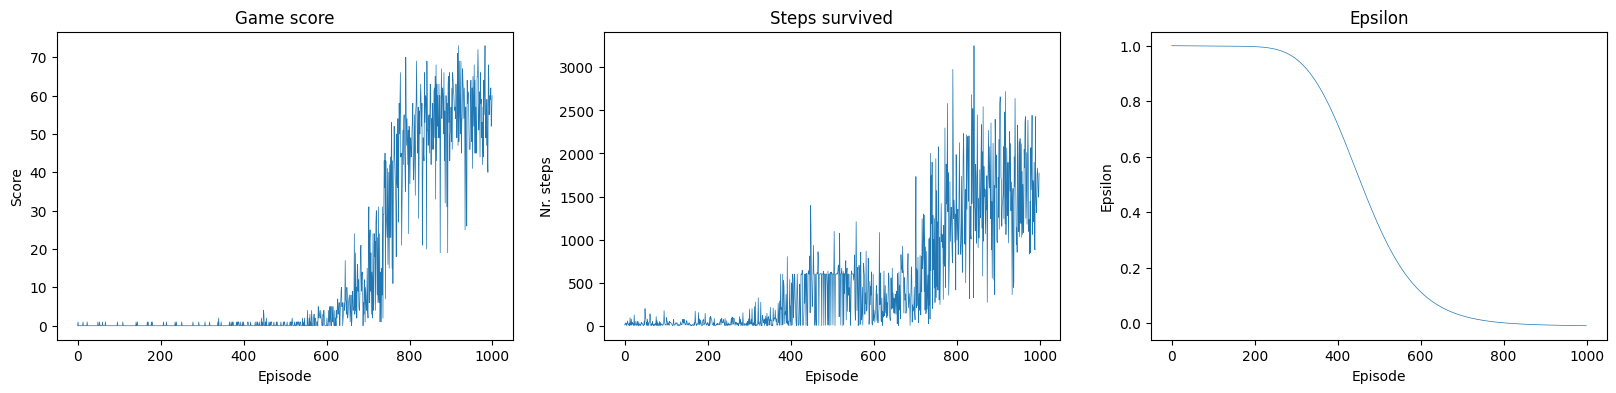

In [5]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot([i for i in range(len(episode_rewards))], episode_rewards,lw=0.5)
ax[0].set_title("Game score")
ax[0].set_xlabel("Episode")
ax[0].set_ylabel("Score")

ax[1].plot([i for i in range(len(episode_durations))], episode_durations,lw=0.5)
ax[1].set_title("Steps survived")
ax[1].set_xlabel("Episode")
ax[1].set_ylabel("Nr. steps")

ax[2].plot([i for i in range(len(episode_exploration_rates))], episode_exploration_rates,lw=0.5)
ax[2].set_title("Epsilon")
ax[2].set_xlabel("Episode")
ax[2].set_ylabel("Epsilon")

plt.show()

In [6]:
avg_period = NUM_EPISODES//100
avg_episode_rewards, avg_episode_durations, avg_episode_exploration_rates = [], [], []
for period in range(0, len(episode_rewards) // avg_period):
    avg_episode_rewards.append(np.mean(episode_rewards[avg_period * period : avg_period * (period + 1)]))
    avg_episode_durations.append(np.mean(episode_durations[avg_period * period : avg_period * (period + 1)]))
    avg_episode_exploration_rates.append(np.mean(episode_exploration_rates[avg_period * period : avg_period * (period + 1)]))

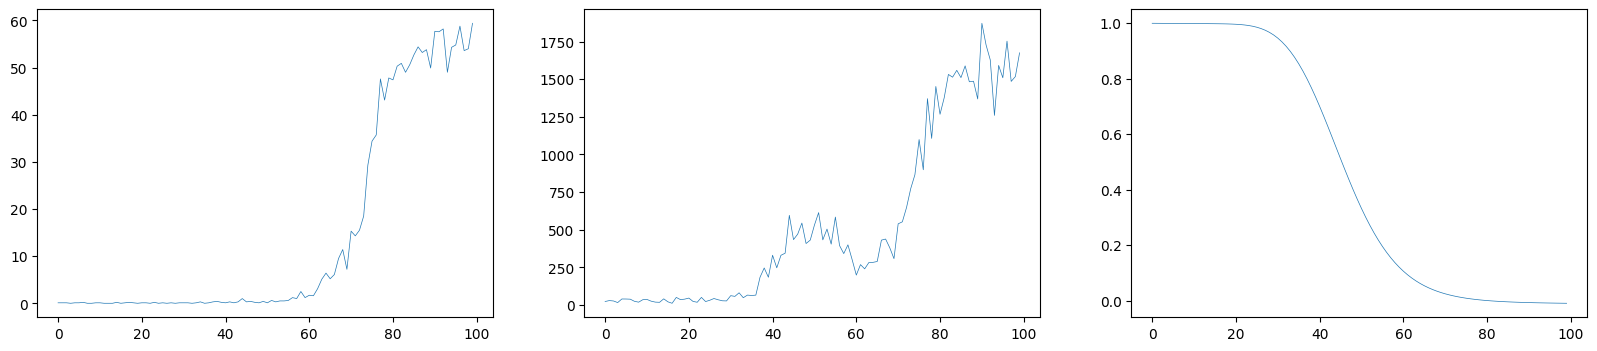

In [7]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot([ i for i in range(len(avg_episode_rewards))], avg_episode_rewards,lw=0.5)
ax[1].plot([ i for i in range(len(avg_episode_durations))], avg_episode_durations,lw=0.5)
ax[2].plot([ i for i in range(len(avg_episode_exploration_rates))], avg_episode_exploration_rates,lw=0.5)
plt.show()

In [21]:
Play_game = True
if Play_game:
    game_env = SnakeEnvironment(seed=1109,  # Try both constant seed and varying seed for each episode
                                neural_net=agent_007.policy_network,
                                display_gameplay=True,
                                graphics_speed=6)
    game_env.run()



In [12]:
for t in tqdm(range(0,10000)):
    game_env = SnakeEnvironment(seed=t,  # Try both constant seed and varying seed for each episode
                                neural_net=agent_007.policy_network,
                                display_gameplay=False,
                                graphics_speed=100)
    game_env.run()
    if game_env.current_score > 90:
        print("seed: ", t, "score: ", game_env.current_score)

 12%|█▏        | 1180/10000 [04:01<30:03,  4.89it/s] 


KeyboardInterrupt: 

In [ ]:
int('001',2)

In [ ]:

[int(i) for i in "{0:b}".format(3)]

In [ ]:
max_len = 400
for _len in range(1,max_len):
    a = [int(i) for i in "{0:b}".format(_len)]
    a += [0 for i in range(9-len(a))]
    if len(a) != 9:
        print(len(a))

In [ ]:
[0 for i in range(int(np.log2(max_len)-np.log2(_len)))]

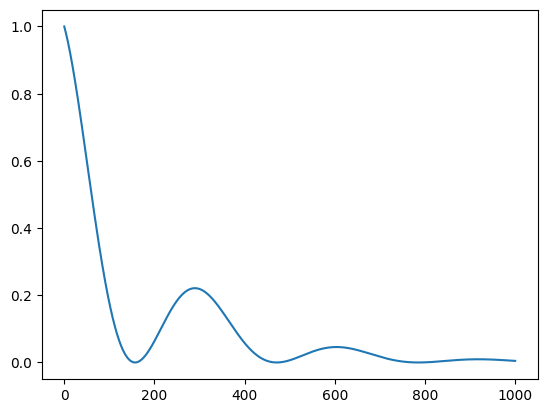

In [21]:
nr_episodes = 1000
xs = np.linspace(0,nr_episodes, 100000)
plt.plot(xs,np.exp(-5/nr_episodes*xs)*np.cos(10/nr_episodes*xs)**2)

In [53]:
screen_size = 150
block_size = 30
s = [Block(rect=FakeRect(2,2,left=i*block_size,top=i*block_size),direction="j") for i in range(4)]
coords = [[_.rect.left // block_size, _.rect.top // block_size] for _ in s]
coords

[[0, 0], [1, 1], [2, 2], [3, 3]]

In [55]:
[0,1] in coords

False

In [60]:
np.random.randint(0, 4,20)

array([2, 3, 0, 0, 1, 3, 0, 2, 1, 3, 0, 0, 1, 2, 2, 3, 0, 0, 0, 2])